In [51]:
# Alejandro Flores Hernández 1709458
# Marc Dalmau Guamis 1710713

import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    f1_score,
    make_scorer,
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import time
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt

In [52]:
cotxes = "Cars_Data_6k.csv"
dftrain = pd.read_csv(cotxes)


Estadísticas descriptivas:
       Unnamed: 0         Year            KM           CV       Length  \
count  5973.00000  5973.000000  5.973000e+03  5973.000000  5973.000000   
mean   2986.00000  2018.005190  8.169198e+04   133.583124     4.348507   
std    1724.40091     3.672202  5.705450e+04    48.986934     0.397570   
min       0.00000  2000.000000  5.000000e+00    20.000000     0.000000   
25%    1493.00000  2016.000000  4.620100e+04   102.000000     4.140000   
50%    2986.00000  2019.000000  7.483600e+04   125.000000     4.360000   
75%    4479.00000  2021.000000  1.088270e+05   150.000000     4.520000   
max    5972.00000  2024.000000  1.116416e+06   498.000000     6.840000   

             Width       Height       Weight        Trunk         Vmax  \
count  5964.000000  5969.000000  5953.000000  4613.000000  5815.000000   
mean      1.800342     1.566710  1387.058458  1334.004336   191.217713   
std       0.112896     0.184844   240.581446   375.613298    20.536075   
min      

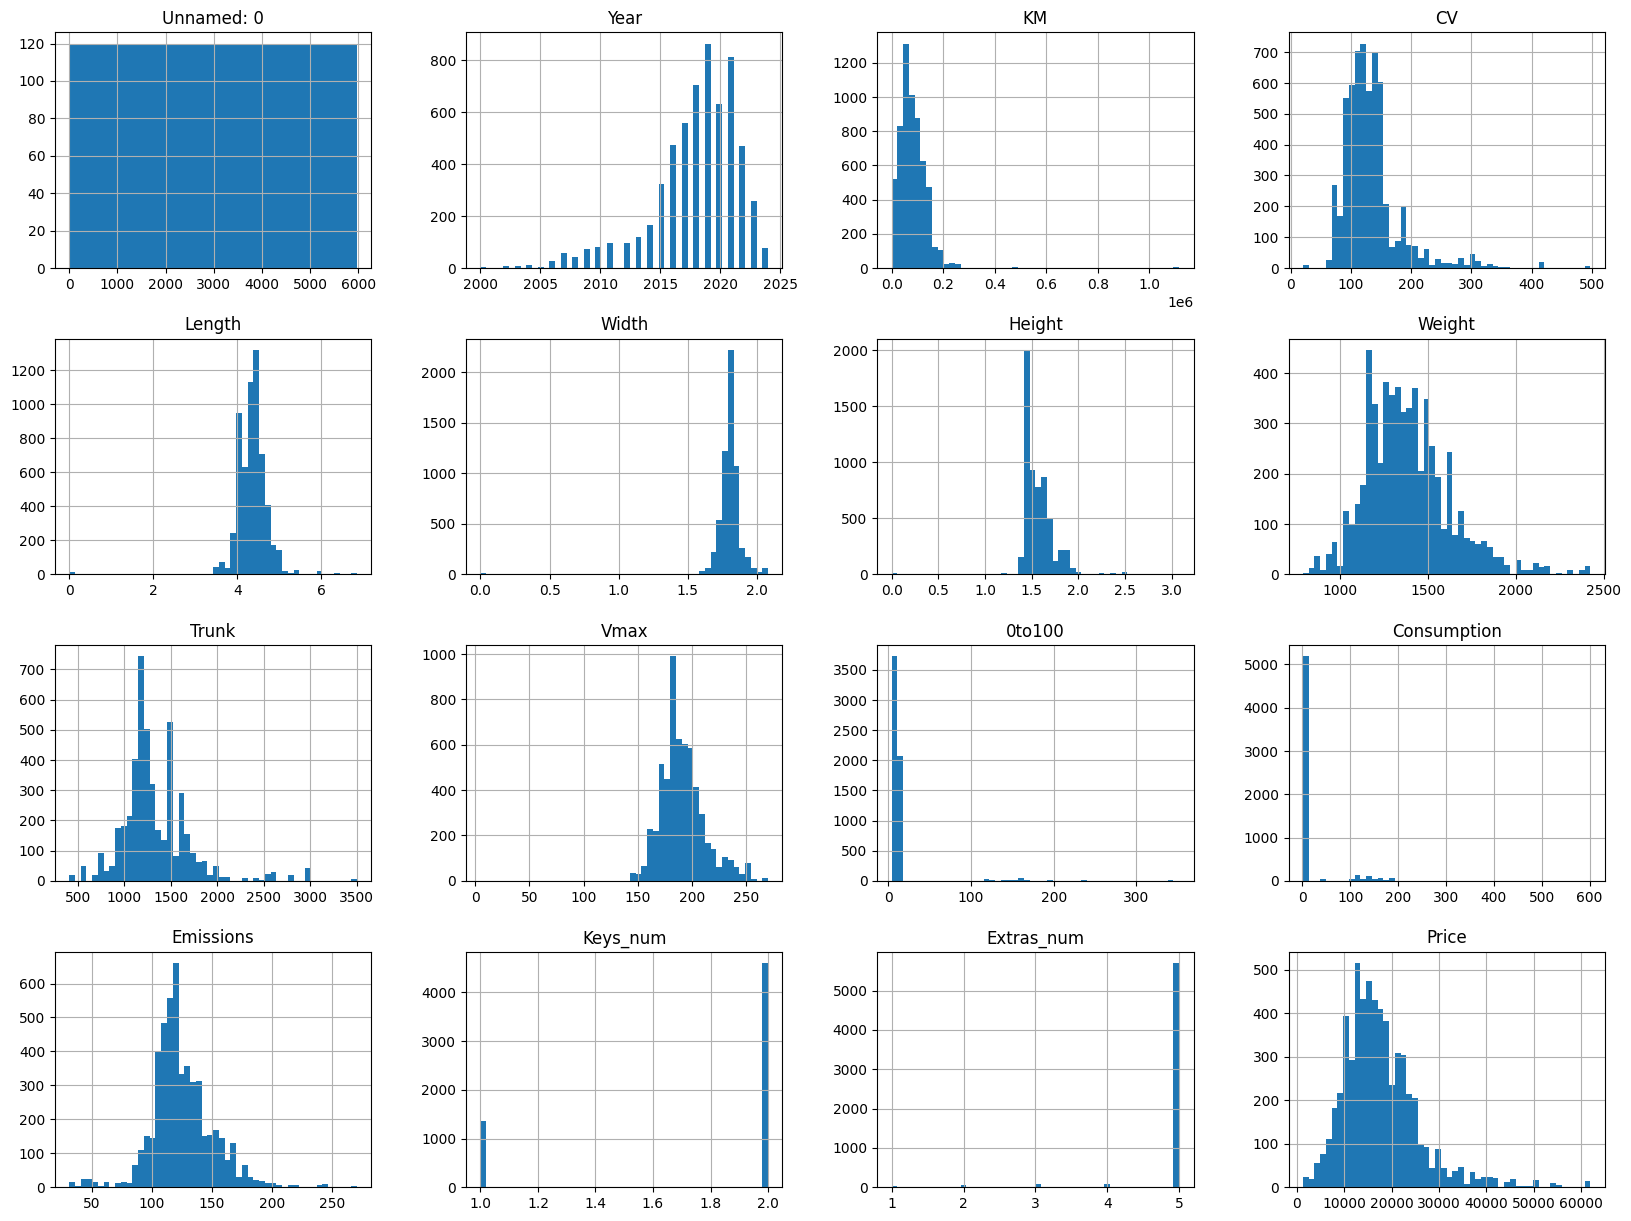

In [53]:
print("\nEstadísticas descriptivas:")
print(dftrain.describe())
#grafic de les dades en histograma
dftrain.hist(bins=50, figsize=(20,15))
plt.show()

In [54]:
#veiem que hi ha columnes amb -s que representen valors nuls
#les substituim per NaN
dftrain.replace("-", np.nan, inplace=True)

C:\Users\aleja\AppData\Local\Temp\ipykernel_17860\562233532.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dftrain.replace("-", np.nan, inplace=True)


In [55]:
# Mirem si hi ha nans a les dades de train

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)
#treiem tank ja que esta buida sencera
dftrain = dftrain.drop(columns=["Tank"])



Percentatge de dades del train que falten per variable:

Tank            100.000000
Trunk            22.769128
Location         18.951950
Emissions        14.716223
Consumption       3.047045
Vmax              2.645237
0to100            0.435292
Sticker           0.418550
Weight            0.334840
Width             0.150678
Height            0.066968
KM                0.000000
Name              0.000000
Brand             0.000000
Unnamed: 0        0.000000
Year              0.000000
CV                0.000000
Fuel              0.000000
Length            0.000000
Transmission      0.000000
One_owner         0.000000
Keys_num          0.000000
Extras_num        0.000000
Price             0.000000
dtype: float64


In [56]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Copia del dataframe original
df = dftrain.copy()

# Separar columnas por tipo
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# -----------------------------------------
# 1. Imputación de columnas NUMÉRICAS con KNN
# -----------------------------------------

# Escalar solo las numéricas
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_cols])

# Aplicar KNN Imputer
imputer = KNNImputer(n_neighbors=5)
X_num_imputed_scaled = imputer.fit_transform(X_num)

# Desescalar numéricas
X_num_imputed = scaler.inverse_transform(X_num_imputed_scaled)

# Crear dataframe final numérico
df_num_final = pd.DataFrame(X_num_imputed, columns=num_cols)

# -----------------------------------------
# 2. Imputación de columnas CATEGÓRICAS con la moda
# -----------------------------------------

df_cat_final = df[cat_cols].copy()

for col in cat_cols:
    df_cat_final[col] = df_cat_final[col].fillna(df_cat_final[col].mode()[0]) #CANVIAR 

# -----------------------------------------
# 3. Reconstruir el dataframe COMPLETO (sin errores)
# -----------------------------------------

df_knn = df.copy()  # copia estructura original

# Reemplazar numéricas y categóricas con las imputadas
df_knn[num_cols] = df_num_final[num_cols]
df_knn[cat_cols] = df_cat_final[cat_cols]

# Comprobación final
print("NaNs restantes por columna:")
print(df_knn.isnull().sum())

# Guardar como nuevo dftrain
dftrain = df_knn.copy()


NaNs restantes por columna:
Unnamed: 0      0
Brand           0
Name            0
Sticker         0
Year            0
KM              0
Fuel            0
CV              0
Transmission    0
One_owner       0
Location        0
Length          0
Width           0
Height          0
Weight          0
Trunk           0
Vmax            0
0to100          0
Consumption     0
Emissions       0
Keys_num        0
Extras_num      0
Price           0
dtype: int64


In [57]:

"""
#numeriques amb pocs NaNs → mitjana
num_pocs_nans = ["Consumption", "Vmax", "0to100", "Weight", "Width", "Height"]

for col in num_pocs_nans:
    dftrain[col].fillna(dftrain[col].mean(), inplace=True)

#categoriquees amb pocs NaNs → moda
cat_pocs_nans = ["Sticker"]   
for col in cat_pocs_nans:
    mode_val = dftrain[col].mode()
    fill_val = mode_val[0] if not mode_val.empty else "Unknown"
    dftrain[col].fillna(fill_val, inplace=True)
"""

'\n#numeriques amb pocs NaNs → mitjana\nnum_pocs_nans = ["Consumption", "Vmax", "0to100", "Weight", "Width", "Height"]\n\nfor col in num_pocs_nans:\n    dftrain[col].fillna(dftrain[col].mean(), inplace=True)\n\n#categoriquees amb pocs NaNs → moda\ncat_pocs_nans = ["Sticker"]   \nfor col in cat_pocs_nans:\n    mode_val = dftrain[col].mode()\n    fill_val = mode_val[0] if not mode_val.empty else "Unknown"\n    dftrain[col].fillna(fill_val, inplace=True)\n'

In [58]:
"""from sklearn.impute import KNNImputer

cols_impute = ["Trunk", "Emissions", "Location"]
df = dftrain.copy()
le_loc = LabelEncoder()

df["Location"] = df["Location"].astype(str)
df["Location_enc"] = le_loc.fit_transform(df["Location"])
cols_for_knn = ["Trunk", "Emissions", "Location_enc"]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[cols_for_knn])
imputer = KNNImputer(n_neighbors=5)

df_imputed_scaled = imputer.fit_transform(df_scaled)

df_imputed = scaler.inverse_transform(df_imputed_scaled)

df[["Trunk", "Emissions", "Location_enc"]] = df_imputed

df["Location_enc"] = df["Location_enc"].round().astype(int)
df["Location"] = le_loc.inverse_transform(df["Location_enc"])

df.drop(columns=["Location_enc"], inplace=True)


print("NaNs restantes por columna:")
print(df.isnull().sum())



"""


'from sklearn.impute import KNNImputer\n\ncols_impute = ["Trunk", "Emissions", "Location"]\ndf = dftrain.copy()\nle_loc = LabelEncoder()\n\ndf["Location"] = df["Location"].astype(str)\ndf["Location_enc"] = le_loc.fit_transform(df["Location"])\ncols_for_knn = ["Trunk", "Emissions", "Location_enc"]\n\nscaler = StandardScaler()\ndf_scaled = scaler.fit_transform(df[cols_for_knn])\nimputer = KNNImputer(n_neighbors=5)\n\ndf_imputed_scaled = imputer.fit_transform(df_scaled)\n\ndf_imputed = scaler.inverse_transform(df_imputed_scaled)\n\ndf[["Trunk", "Emissions", "Location_enc"]] = df_imputed\n\ndf["Location_enc"] = df["Location_enc"].round().astype(int)\ndf["Location"] = le_loc.inverse_transform(df["Location_enc"])\n\ndf.drop(columns=["Location_enc"], inplace=True)\n\n\nprint("NaNs restantes por columna:")\nprint(df.isnull().sum())\n\n\n\n'

In [59]:
print(dftrain.head())

   Unnamed: 0    Brand            Name Sticker    Year       KM      Fuel  \
0         0.0     Opel      Opel Corsa       C  2022.0  47707.0    Diésel   
1         1.0  Peugeot  Peugeot Rifter       C  2019.0  57194.0    Diésel   
2         2.0  Renault  Renault Kadjar       C  2017.0  66428.0    Diésel   
3         3.0    Dacia   Dacia Sandero       C  2016.0  48430.0  Gasolina   
4         4.0   Nissan  Nissan QASHQAI       C  2020.0  72209.0  Gasolina   

      CV Transmission  One_owner  ... Height  Weight   Trunk   Vmax  0to100  \
0  102.0       MANUAL       True  ...   1.43  1165.0  1069.0  188.0    10.2   
1  130.0         AUTO       True  ...   1.82  1430.0  1355.0  179.0     4.3   
2  110.0       MANUAL      False  ...   1.61  1380.0  1478.0  182.0    11.9   
3   75.0       MANUAL       True  ...   1.52   941.0  1200.0  162.0    14.5   
4  160.0         AUTO      False  ...   1.59  1315.0  1598.0  198.0     9.9   

   Consumption  Emissions  Keys_num  Extras_num    Price  
0  

In [60]:
# Mirem si hi ha nans a les dades de train

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)

#

Percentatge de dades del train que falten per variable:

Unnamed: 0      0.0
Brand           0.0
Name            0.0
Sticker         0.0
Year            0.0
KM              0.0
Fuel            0.0
CV              0.0
Transmission    0.0
One_owner       0.0
Location        0.0
Length          0.0
Width           0.0
Height          0.0
Weight          0.0
Trunk           0.0
Vmax            0.0
0to100          0.0
Consumption     0.0
Emissions       0.0
Keys_num        0.0
Extras_num      0.0
Price           0.0
dtype: float64


In [61]:
"""# Pasem a numèriques les variables categòriques
sticker = LabelEncoder()
fuel = LabelEncoder()
transmission = LabelEncoder()
owner = LabelEncoder()
name= LabelEncoder()
brand= LabelEncoder()   
location = LabelEncoder()
#pasem de dades categoriques a numeriques
dftrain["Sticker"] = sticker.fit_transform(dftrain["Sticker"])
dftrain["Fuel"] = fuel.fit_transform(dftrain["Fuel"])
dftrain["Transmission"] = transmission.fit_transform(dftrain["Transmission"])
dftrain["One_owner"] = owner.fit_transform(dftrain["One_owner"])
dftrain["Name"] = name.fit_transform(dftrain["Name"])
dftrain["Brand"] = brand.fit_transform(dftrain["Brand"])
dftrain["Location"] = location.fit_transform(dftrain["Location"])"""

'# Pasem a numèriques les variables categòriques\nsticker = LabelEncoder()\nfuel = LabelEncoder()\ntransmission = LabelEncoder()\nowner = LabelEncoder()\nname= LabelEncoder()\nbrand= LabelEncoder()   \nlocation = LabelEncoder()\n#pasem de dades categoriques a numeriques\ndftrain["Sticker"] = sticker.fit_transform(dftrain["Sticker"])\ndftrain["Fuel"] = fuel.fit_transform(dftrain["Fuel"])\ndftrain["Transmission"] = transmission.fit_transform(dftrain["Transmission"])\ndftrain["One_owner"] = owner.fit_transform(dftrain["One_owner"])\ndftrain["Name"] = name.fit_transform(dftrain["Name"])\ndftrain["Brand"] = brand.fit_transform(dftrain["Brand"])\ndftrain["Location"] = location.fit_transform(dftrain["Location"])'

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3864984167.py, line 19)

In [63]:
"""print("Correspondències valors de la variable Sticker:\n")
for i, cat in enumerate(sticker.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable Fuel:\n")
for i, cat in enumerate(fuel.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable Transmission:\n")
for i, cat in enumerate(transmission.classes_):
    print(i, "->", cat)

print("\nCorrespondències valors de la variable One_owner:\n")
for i, cat in enumerate(owner.classes_):
    print(i, "->", cat)"""


'print("Correspondències valors de la variable Sticker:\n")\nfor i, cat in enumerate(sticker.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable Fuel:\n")\nfor i, cat in enumerate(fuel.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable Transmission:\n")\nfor i, cat in enumerate(transmission.classes_):\n    print(i, "->", cat)\n\nprint("\nCorrespondències valors de la variable One_owner:\n")\nfor i, cat in enumerate(owner.classes_):\n    print(i, "->", cat)'

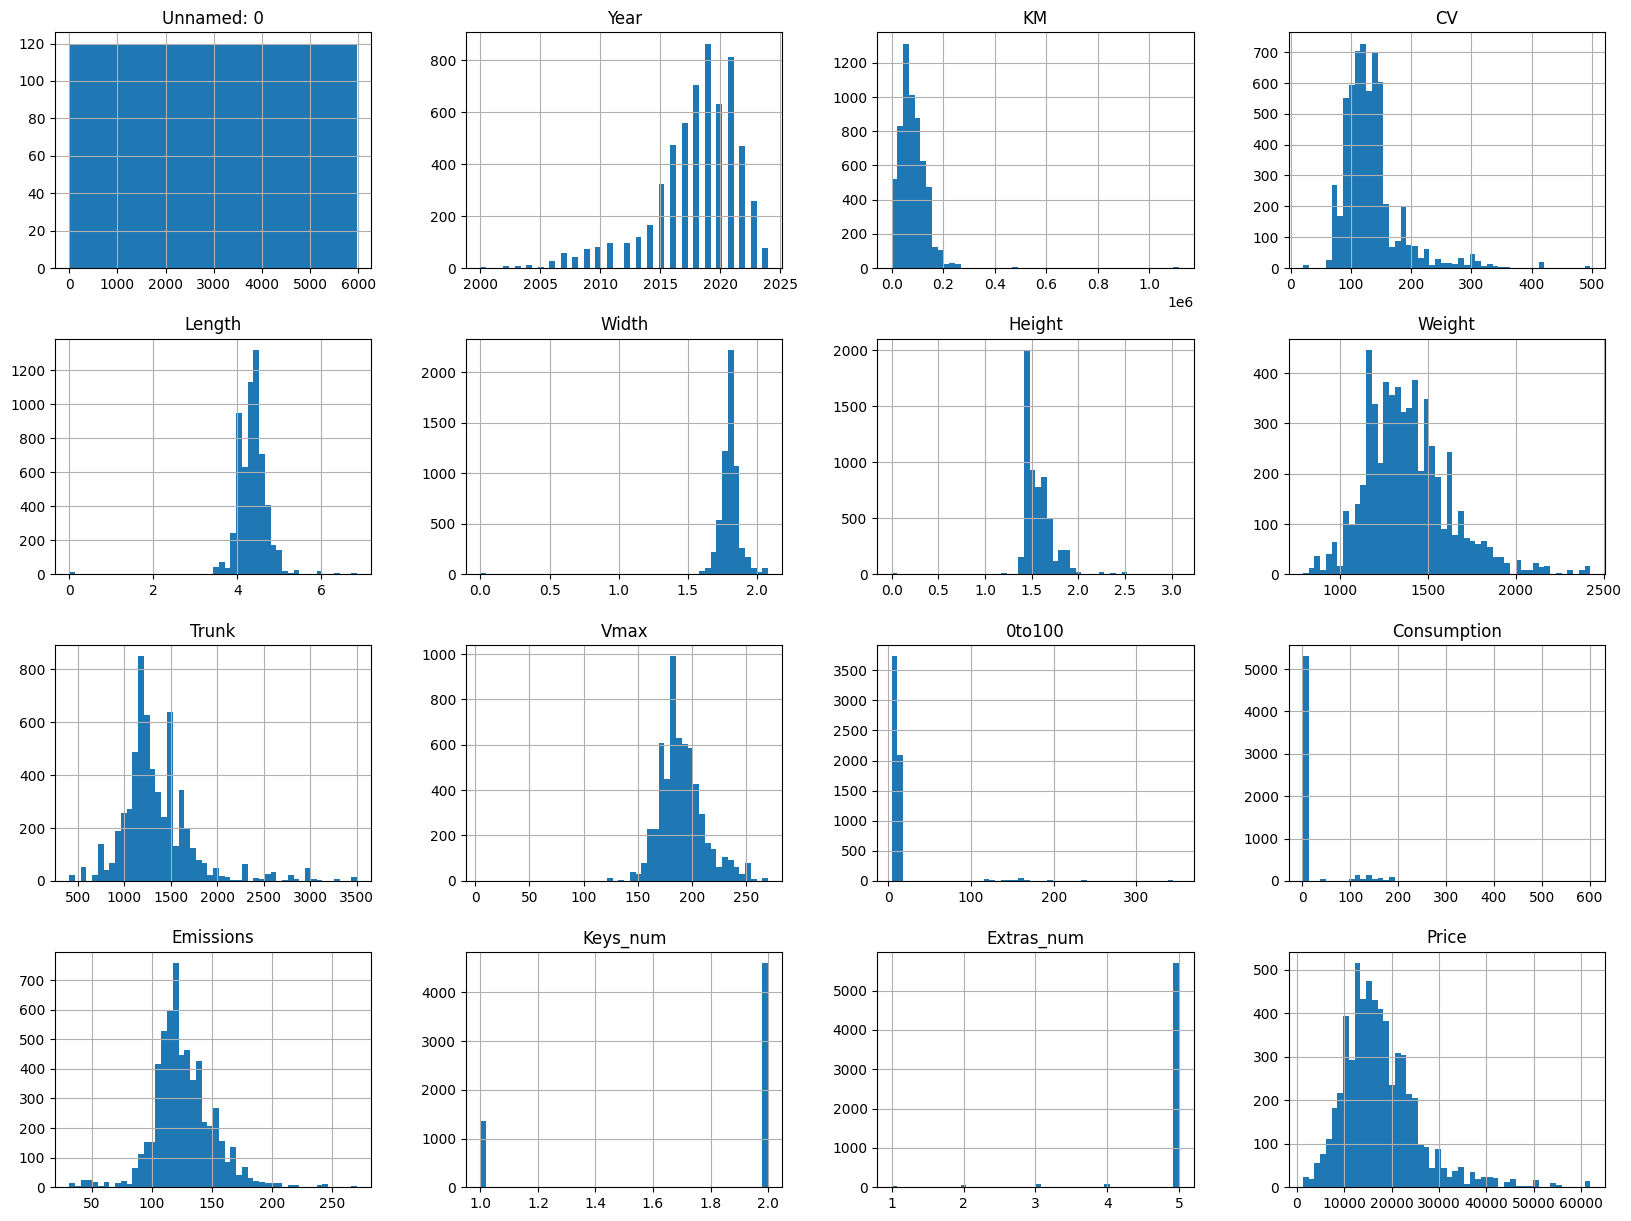

In [64]:
#grafic de les dades en histograma
dftrain.hist(bins=50, figsize=(20,15))
plt.show()

In [65]:
#crear noves mitjanes, per exemple preu mitjà per marca i model o preu per model NOU
import pandas as pd

# --- Basic aggregations per Brand ---
dftrain['brand_mean_price'] = dftrain.groupby('Brand')['Price'].transform('mean')
dftrain['brand_max_price']  = dftrain.groupby('Brand')['Price'].transform('max')
dftrain['brand_min_price']  = dftrain.groupby('Brand')['Price'].transform('min')

# --- Aggregations per Model (Brand + Name) ---
dftrain['model_mean_price'] = dftrain.groupby(['Brand', 'Name'])['Price'].transform('mean')
dftrain['model_max_price']  = dftrain.groupby(['Brand', 'Name'])['Price'].transform('max')
dftrain['model_min_price']  = dftrain.groupby(['Brand', 'Name'])['Price'].transform('min')

In [66]:
#normalitzem les dades
scaler = StandardScaler()

#deixem fora les columnes no numeriques
cols_to_scale=[
    "Year",
    "KM",
    "CV",
    "Length",
    "Width",
    "Height",
    "Weight",
    "Trunk",
    "Vmax",
    "0to100",
    "Consumption",
    "Emissions",
    "Keys_num",
    "Extras_num",
    "brand_mean_price",
    "brand_max_price",
    "brand_min_price",
    "model_mean_price",
    "model_max_price",
    "model_min_price",
]
cols_not_scaled = [
    "Brand",
    "Name",
    "Sticker",
    "Fuel",
    "Transmission",
    "One_owner",
    "Location",
]

df_scaled_values = scaler.fit_transform(dftrain[cols_to_scale])
df_scaled = pd.DataFrame(df_scaled_values, columns=cols_to_scale, index=df.index)
df_final = pd.concat([df_scaled, dftrain[cols_not_scaled],dftrain["Price"]], axis=1)
print(df_final.head())





       Year        KM        CV    Length     Width    Height    Weight  \
0  1.087942 -0.595708 -0.644779 -0.725735 -0.269508 -0.739005 -0.924807   
1  0.270926 -0.429414 -0.073151  0.129531  0.439627  1.362167  0.176627   
2 -0.273752 -0.267556 -0.481457  0.255306  0.350985  0.230767 -0.031190   
3 -0.546091 -0.583035 -1.195993 -0.725735 -0.624076 -0.254119 -1.855830   
4  0.543264 -0.166223  0.539309  0.104376  0.085059  0.123014 -0.301353   

      Trunk      Vmax    0to100  ...  model_max_price  model_min_price  \
0 -0.713341 -0.123165 -0.141901  ...        -0.940605        -0.947395   
1  0.005873 -0.554348 -0.365804  ...         0.733813        -0.200456   
2  0.315185 -0.410620 -0.077386  ...        -0.088836         0.395835   
3 -0.383911 -1.368804  0.021283  ...        -0.774204        -0.865130   
4  0.616953  0.355927 -0.153285  ...         0.649572        -0.555352   

     Brand            Name  Sticker      Fuel  Transmission  One_owner  \
0     Opel      Opel Corsa    

In [67]:
#COMPROVACIÓ NANS

missing_percent_train = dftrain.isnull().mean() * 100

missing_percent_train = missing_percent_train.sort_values(ascending=False)

print("Percentatge de dades del train que falten per variable:\n")
print(missing_percent_train)


Percentatge de dades del train que falten per variable:

Unnamed: 0          0.0
Brand               0.0
Name                0.0
Sticker             0.0
Year                0.0
KM                  0.0
Fuel                0.0
CV                  0.0
Transmission        0.0
One_owner           0.0
Location            0.0
Length              0.0
Width               0.0
Height              0.0
Weight              0.0
Trunk               0.0
Vmax                0.0
0to100              0.0
Consumption         0.0
Emissions           0.0
Keys_num            0.0
Extras_num          0.0
Price               0.0
brand_mean_price    0.0
brand_max_price     0.0
brand_min_price     0.0
model_mean_price    0.0
model_max_price     0.0
model_min_price     0.0
dtype: float64


In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación Spearman (incluye solo numéricas automáticamente)
corr_matrix = df_final.corr(method="spearman")

plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Matriu de correlació (Spearman)")
plt.show()

# Variables ordenadas por correlación con Price
corr_with_price = corr_matrix["Price"].sort_values(ascending=False)
print(corr_with_price)


ValueError: could not convert string to float: 'Opel'

In [ ]:
X = df_final.drop(columns=["Price"])
y = df_final["Price"]


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
# === IMPORTS COMPLETOS PARA TODOS LOS MODELOS ===

# Modelos lineales
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    BayesianRidge,
    SGDRegressor
)

# Árboles y modelos de ensamble
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)

# Vecinos
from sklearn.neighbors import KNeighborsRegressor

# Máquinas de soporte vectorial
from sklearn.svm import SVR

# Procesos Gaussianos
from sklearn.gaussian_process import GaussianProcessRegressor

# Partial Least Squares
from sklearn.cross_decomposition import PLSRegression

# Selección de características
from sklearn.feature_selection import SequentialFeatureSelector

# Validación cruzada
from sklearn.model_selection import KFold

# Otras utilidades
import pandas as pd
import numpy as np


# --- KFold para cross-validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- MODELOS ---
modelos_estimadores = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "BayesianRidge": BayesianRidge(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42, max_depth=5),
    "RandomForest": RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "SVR_linear": SVR(kernel="linear"),
    "SVR_rbf": SVR(kernel="rbf"),
    "DecisionTree_max_depth3": DecisionTreeRegressor(max_depth=3, random_state=42),
    "RandomForest_max_depth10": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42),
    "GradientBoosting_lr05": GradientBoostingRegressor(learning_rate=0.05, n_estimators=50, max_depth=3, random_state=42),
    "ElasticNet_l1": ElasticNet(alpha=0.01, l1_ratio=1.0),
    "ElasticNet_l2": ElasticNet(alpha=0.01, l1_ratio=0.0),
    "SGDRegressor_huber": SGDRegressor(loss="huber", max_iter=1000, tol=1e-3, random_state=42)
}

"""

# --- Diccionario para guardar las variables seleccionadas ---
sfs_selected_features = {}

print("\n=== INICIANDO SELECCIÓN DE FEATURES ===")
print("Modelos totales:", len(modelos_estimadores))

# --- Bucle sobre modelos ---
for nombre_modelo, modelo in modelos_estimadores.items():
    print(f"\nProcesando {nombre_modelo}...")

    try:
        sfs = SequentialFeatureSelector(
            modelo,
            n_features_to_select="auto",   # BEST: selecciona número óptimo de features
            direction="forward",
            scoring="neg_mean_squared_error",
            cv=cv,
            n_jobs=-1
        )

        sfs.fit(X, y)
        selected_features = list(X.columns[sfs.get_support()])
        sfs_selected_features[nombre_modelo] = selected_features

        print(f"FEATURES seleccionados ({nombre_modelo}): {selected_features}")

    except Exception as e:
        print(f" Error en {nombre_modelo}: {e}")
        sfs_selected_features[nombre_modelo] = None


print("\n=== RESULTADO FINAL ===")
for modelo, features in sfs_selected_features.items():
    print(f"{modelo}: {features}")"""


'\n\n# --- Diccionario para guardar las variables seleccionadas ---\nsfs_selected_features = {}\n\nprint("\n=== INICIANDO SELECCIÓN DE FEATURES ===")\nprint("Modelos totales:", len(modelos_estimadores))\n\n# --- Bucle sobre modelos ---\nfor nombre_modelo, modelo in modelos_estimadores.items():\n    print(f"\nProcesando {nombre_modelo}...")\n\n    try:\n        sfs = SequentialFeatureSelector(\n            modelo,\n            n_features_to_select="auto",   # BEST: selecciona número óptimo de features\n            direction="forward",\n            scoring="neg_mean_squared_error",\n            cv=cv,\n            n_jobs=-1\n        )\n\n        sfs.fit(X, y)\n        selected_features = list(X.columns[sfs.get_support()])\n        sfs_selected_features[nombre_modelo] = selected_features\n\n        print(f"FEATURES seleccionados ({nombre_modelo}): {selected_features}")\n\n    except Exception as e:\n        print(f" Error en {nombre_modelo}: {e}")\n        sfs_selected_features[nombre_mod

In [ ]:
modelos_columnas = {
    "LinearRegression": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                         'Emissions', 'brand_mean_price', 'brand_min_price',
                         'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "Ridge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
              'Emissions', 'brand_mean_price', 'brand_min_price',
              'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "Lasso": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
              'Emissions', 'brand_mean_price', 'brand_min_price',
              'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "ElasticNet": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                   'Emissions', 'brand_mean_price', 'brand_min_price',
                   'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "BayesianRidge": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "SGDRegressor": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                     'Emissions', 'brand_mean_price', 'brand_min_price',
                     'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "DecisionTree": ['Year', 'CV', 'Length', 'Height', '0to100', 'Consumption',
                     'Emissions', 'Keys_num', 'Extras_num',
                     'model_mean_price', 'model_max_price', 'model_min_price',
                     'Transmission'],

    "RandomForest": ['Year', 'KM', 'CV', 'Length', 'Height', 'Vmax', '0to100',
                     'Emissions', 'model_mean_price', 'model_max_price',
                     'model_min_price', 'Transmission', 'Location'],

    "GradientBoosting": ['Year', 'KM', 'CV', 'Width', 'Keys_num',
                         'brand_max_price', 'brand_min_price',
                         'model_mean_price', 'model_max_price',
                         'model_min_price', 'Brand', 'Transmission', 'Location'],

    "AdaBoost": ['Year', 'CV', 'Weight', 'Trunk', '0to100', 'Emissions',
                 'Keys_num', 'Extras_num', 'model_mean_price',
                 'Name', 'Fuel', 'One_owner', 'Location'],

    "KNeighbors": ['Year', 'KM', 'CV', 'Height', 'Weight', 'Trunk', 'Vmax',
                   'Consumption', 'Extras_num', 'model_mean_price',
                   'model_max_price', 'model_min_price', 'Transmission'],

    "SVR_linear": ['Year', 'KM', 'CV', 'Weight', 'Vmax', 'Emissions', 'Keys_num',
                   'brand_mean_price', 'model_mean_price',
                   'model_max_price', 'model_min_price', 'Sticker', 'Transmission'],

    "SVR_rbf": ['Year', 'KM', 'CV', 'Length', 'Width', 'Weight', 'Vmax',
                '0to100', 'model_mean_price', 'model_max_price',
                'model_min_price', 'Sticker', 'Transmission'],

    "DecisionTree_max_depth3": ['Year', 'Length', 'Width', 'Height', 'Weight',
                                'Trunk', 'Consumption', 'Keys_num', 'Extras_num',
                                'brand_mean_price', 'brand_max_price',
                                'brand_min_price', 'model_mean_price'],

    "RandomForest_max_depth10": ['Year', 'KM', 'CV', 'Length', 'Height', 'Weight',
                                 '0to100', 'Emissions', 'model_mean_price',
                                 'model_max_price', 'model_min_price',
                                 'Transmission', 'Location'],

    "GradientBoosting_lr05": ['Year', 'KM', 'CV', 'Consumption', 'Emissions',
                              'Keys_num', 'brand_max_price', 'model_mean_price',
                              'model_max_price', 'model_min_price', 'Brand',
                              'Transmission', 'Location'],

    "ElasticNet_l1": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "ElasticNet_l2": ['Year', 'KM', 'CV', 'Width', 'Height', 'Consumption',
                      'Emissions', 'brand_mean_price', 'brand_min_price',
                      'model_mean_price', 'Sticker', 'Fuel', 'Transmission'],

    "SGDRegressor_huber": ['Year', 'CV', 'Length', 'Weight', 'Vmax',
                           'brand_mean_price', 'model_mean_price',
                           'model_max_price', 'model_min_price', 'Brand',
                           'Sticker', 'Fuel', 'Location']
}


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )


label_encoders = {
    "Sticker": sticker,
    "Fuel": fuel,
    "Transmission": transmission,
    "One_owner": owner,
    "Name": name,
    "Brand": brand,
    "Location": location
}
# --- Cross-validation ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)  # negativo para que cross_val_score funcione

# --- Diccionario para almacenar los resultados ---
model_scores = {}

# --- Evaluar cada modelo con sus variables seleccionadas ---
for nombre_modelo, modelo in modelos_estimadores.items():
    features = modelos_columnas.get(nombre_modelo)
    
    if features is None or len(features) == 0:
        print(f"{nombre_modelo} no tiene variables seleccionadas, se omite.")
        model_scores[nombre_modelo] = None
        continue
    
    X_subset = X_train[features]
    
    try:
        scores = cross_val_score(modelo, X_subset, y_train, cv=cv, scoring=mse_scorer, n_jobs=-1)
        mean_score = -np.mean(scores)  # convertir de negativo a positivo
        model_scores[nombre_modelo] = mean_score
        print(f"{nombre_modelo} - MSE promedio: {mean_score:.4f}")
    
    except Exception as e:
        print(f"Error evaluando {nombre_modelo}: {e}")
        model_scores[nombre_modelo] = None

# --- Elegir el mejor modelo ---
best_model = min((mse, mdl) for mdl, mse in model_scores.items() if mse is not None)
print(f"\nMejor modelo: {best_model[1]} con MSE = {best_model[0]:.4f}")


LinearRegression - MSE promedio: 8635084.2988
Ridge - MSE promedio: 8635037.3749
Lasso - MSE promedio: 8635082.6299
ElasticNet - MSE promedio: 8635228.0344
BayesianRidge - MSE promedio: 8634998.3265
SGDRegressor - MSE promedio: 8738317.0569
DecisionTree - MSE promedio: 11287307.5655
RandomForest - MSE promedio: 7844446.7032
GradientBoosting - MSE promedio: 4862112.9955
AdaBoost - MSE promedio: 11038822.5147
KNeighbors - MSE promedio: 2405549.6341
SVR_linear - MSE promedio: 14477720.2553
SVR_rbf - MSE promedio: 62208856.7753
DecisionTree_max_depth3 - MSE promedio: 19644969.1425
RandomForest_max_depth10 - MSE promedio: 1436659.8501
GradientBoosting_lr05 - MSE promedio: 8019204.7771
ElasticNet_l1 - MSE promedio: 8635082.6299
ElasticNet_l2 - MSE promedio: 8637471.9291
SGDRegressor_huber - MSE promedio: 102564143.4611

Mejor modelo: RandomForest_max_depth10 con MSE = 1436659.8501


In [ ]:
def predecir_precio_ciudad(nuevo_auto, dftrain, modelo, modelo_name, modelos_dic, scaler=None, encode_dict=None):

    # ------ Helper para crear df_pred y aplicarle TODO ------
    def preparar_prediccion(auto_info):

        df_pred = pd.DataFrame([auto_info])

        # Codificar
        if encode_dict is not None:
            for col, le in encode_dict.items():
                if col in df_pred.columns:
                    df_pred[col] = le.transform(df_pred[col])

        brand = df_pred["Brand"].iloc[0]
        name  = df_pred["Name"].iloc[0]

        df_brand = dftrain[dftrain["Brand"] == brand]
        df_model = dftrain[(dftrain["Brand"] == brand) & (dftrain["Name"] == name)]

        def safe_value(series, default):
            return series[0] if len(series) > 0 else default

        df_pred["brand_mean_price"] = safe_value(df_brand["brand_mean_price"].unique(), dftrain["Price"].mean())
        df_pred["brand_max_price"]  = safe_value(df_brand["brand_max_price"].unique(), dftrain["Price"].max())
        df_pred["brand_min_price"]  = safe_value(df_brand["brand_min_price"].unique(), dftrain["Price"].min())

        df_pred["model_mean_price"] = safe_value(df_model["model_mean_price"].unique(), dftrain["Price"].mean())
        df_pred["model_max_price"]  = safe_value(df_model["model_max_price"].unique(), dftrain["Price"].max())
        df_pred["model_min_price"]  = safe_value(df_model["model_min_price"].unique(), dftrain["Price"].min())
        

        # Scaling
        if scaler is not None:
            scaler_cols = scaler.feature_names_in_

            for col in scaler_cols:
                if col not in df_pred.columns:
                    df_pred[col] = dftrain[col].mean() if col in dftrain.columns else 0

            df_pred[scaler_cols] = scaler.transform(df_pred[scaler_cols])

        features = modelos_dic[modelo_name]

        for col in features:
            if col not in df_pred.columns:
                df_pred[col] = 0

        return df_pred[features]

    # ----- Predicción base -----
    X_base = preparar_prediccion(nuevo_auto)
    precio_estimado = float(modelo.predict(X_base)[0])

    # ----- PREDECIR TODAS LAS CIUDADES -----
    todas_ciudades_codificadas = dftrain["Location"].unique()
    precios_ciudades = {}

    for loc in todas_ciudades_codificadas:

        # decodificar número → nombre
        if "Location" in encode_dict:
            ciudad_nombre = encode_dict["Location"].inverse_transform([loc])[0]
        else:
            ciudad_nombre = loc

        auto_copia = nuevo_auto.copy()
        auto_copia["Location"] = ciudad_nombre  # usar nombre

        X_city = preparar_prediccion(auto_copia)
        pred_city = float(modelo.predict(X_city)[0])

        precios_ciudades[ciudad_nombre] = pred_city

    # Ordenar ciudades por precio
    ciudades_ordenadas = dict(
        sorted(precios_ciudades.items(), key=lambda x: x[1], reverse=True)
    )

    ciudad_mejor = list(ciudades_ordenadas.keys())[0]

    return precio_estimado, ciudad_mejor, ciudades_ordenadas


In [ ]:
# --- Obtener el mejor modelo a partir del diccionario de scores ---
best_model = min((mse, mdl) for mdl, mse in model_scores.items() if mse is not None)
best_model_name = best_model[1]  # extraer solo el nombre del modelo
best_model_obj = modelos_estimadores[best_model_name]
features_best = modelos_columnas[best_model_name]

# --- Ajustar el modelo con todas las columnas seleccionadas ---
best_model_obj.fit(X_train[features_best], y_train)

# --- Nuevo coche a predecir ---
nuevo_auto = {
    "Brand": "Dacia",
    "Name": "Dacia Sandero",
    "Year": 2015,
    "KM": 68000,
    "CV": 90,
    "Fuel": "Gasolina",
    "Transmission": "MANUAL",
    "Length": 406,
    "Width": 173,
    "Height": 152,
    "Weight": 1023,
    "Trunk": 320,
    "Vmax": 168,
    "0to100": 11.1,
    "Consumption": 5.1,
    "Emissions": 115,
    "Keys_num": 2,
    "Extras_num": 3
}

# --- Predicción ---
precio, ciudad_mejor, ciudades_ordenadas = predecir_precio_ciudad(
    nuevo_auto,
    dftrain=dftrain,
    modelo=best_model_obj,
    modelo_name=best_model_name,  # corregido
    modelos_dic=modelos_columnas,
    scaler=scaler,
    encode_dict=label_encoders
)


# --- Obtenir preu màxim ---
primer_parell = list(ciudades_ordenadas.items())[0]
preu_maxim = primer_parell[1]

# --- Llista de ciutats amb el mateix preu ---
ciutats = [ciutat for ciutat, preu in ciudades_ordenadas.items() if preu == preu_maxim]
            

print(f"\nMejor modelo: {best_model_name}")
print(f"Precio estimado: {preu_maxim:.2f}€")
print(f"Ciudad/es sugerida/s para vender: {ciutats}")
print("\nCiudades ordenadas por precio (mayor a menor):")
print(ciudades_ordenadas)



Mejor modelo: RandomForest_max_depth10
Precio estimado: 4912.30€
Ciudad/es sugerida/s para vender: ['Almería', 'Barcelona', 'Alicante', 'Cádiz', 'Girona', 'Castellón', 'Badajoz', 'Albacete', 'Ciudad', 'Gipuzkoa', 'Córdoba', 'Cáceres']

Ciudades ordenadas por precio (mayor a menor):
{'Almería': 4912.299302681992, 'Barcelona': 4912.299302681992, 'Alicante': 4912.299302681992, 'Cádiz': 4912.299302681992, 'Girona': 4912.299302681992, 'Castellón': 4912.299302681992, 'Badajoz': 4912.299302681992, 'Albacete': 4912.299302681992, 'Ciudad': 4912.299302681992, 'Gipuzkoa': 4912.299302681992, 'Córdoba': 4912.299302681992, 'Cáceres': 4912.299302681992, 'Granada': 4910.299302681992, 'Madrid': 4887.935932718622, 'Málaga': 4887.935932718622, 'Murcia': 4887.935932718622, 'Zaragoza': 4887.935932718622, 'Huelva': 4887.935932718622, 'Valencia': 4887.935932718622, 'Sevilla': 4887.935932718622, 'Vizcaya': 4887.935932718622, 'Oviedo': 4887.935932718622, 'La': 4887.935932718622, 'Navarra': 4887.935932718622, 

In [ ]:
"""
# --- Nuevo coche a predecir ---
nuevo_auto = {
    "Brand": "Opel",
    "Name": "Opel Corsa",
    "Year": 2005,
    "KM": 186000,
    "CV": 80,
    "Fuel": "Gasolina",
    "Transmission": "MANUAL",
    "Length": 384,
    "Width": 165,
    "Height": 144,
    "Weight": 1035,
    "Trunk": 260,
    "Vmax": 170,
    "0to100": 13,
    "Consumption": 6,
    "Emissions": 143,
    "Keys_num": 2,
    "Extras_num": 3
}

Mejor modelo: RandomForest_max_depth10
Precio estimado: 4843.65€
Ciudad/es sugerida/s para vender: ['Almería', 'Alicante', 'Badajoz', 'Albacete']

Ciudades ordenadas por precio (mayor a menor):
{'Almería': 4843.645004821242, 'Alicante': 4843.645004821242, 'Badajoz': 4843.645004821242, 'Albacete': 4843.645004821242, 'Barcelona': 4818.311671487909, 'Madrid': 4818.311671487909, 'Málaga': 4818.311671487909, 'Murcia': 4818.311671487909, 'Zaragoza': 4818.311671487909, 'Huelva': 4818.311671487909, 'Valencia': 4818.311671487909, 'Sevilla': 4818.311671487909, 'Cádiz': 4818.311671487909, 'Girona': 4818.311671487909, 'Vizcaya': 4818.311671487909, 'Castellón': 4818.311671487909, 'Oviedo': 4818.311671487909, 'La': 4818.311671487909, 'Granada': 4818.311671487909, 'Navarra': 4818.311671487909, 'Pontevedra': 4818.311671487909, 'Ciudad': 4818.311671487909, 'Toledo': 4818.311671487909, 'Gipuzkoa': 4818.311671487909, 'Córdoba': 4818.311671487909, 'Santander': 4818.311671487909, 'Cáceres': 4818.311671487909, 'Jaén': 4818.311671487909}
"""

'\n# --- Nuevo coche a predecir ---\nnuevo_auto = {\n    "Brand": "Opel",\n    "Name": "Opel Corsa",\n    "Year": 2005,\n    "KM": 186000,\n    "CV": 80,\n    "Fuel": "Gasolina",\n    "Transmission": "MANUAL",\n    "Length": 384,\n    "Width": 165,\n    "Height": 144,\n    "Weight": 1035,\n    "Trunk": 260,\n    "Vmax": 170,\n    "0to100": 13,\n    "Consumption": 6,\n    "Emissions": 143,\n    "Keys_num": 2,\n    "Extras_num": 3\n}\n\nMejor modelo: RandomForest_max_depth10\nPrecio estimado: 4843.65€\nCiudad/es sugerida/s para vender: [\'Almería\', \'Alicante\', \'Badajoz\', \'Albacete\']\n\nCiudades ordenadas por precio (mayor a menor):\n{\'Almería\': 4843.645004821242, \'Alicante\': 4843.645004821242, \'Badajoz\': 4843.645004821242, \'Albacete\': 4843.645004821242, \'Barcelona\': 4818.311671487909, \'Madrid\': 4818.311671487909, \'Málaga\': 4818.311671487909, \'Murcia\': 4818.311671487909, \'Zaragoza\': 4818.311671487909, \'Huelva\': 4818.311671487909, \'Valencia\': 4818.311671487909,